In [3]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
! nvidia-smi

Mon May 18 07:47:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00001441:00:00.0 Off |                    0 |
| N/A   60C    P0    58W / 149W |    687MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00003533:00:00.0 Off |                    0 |
| N/A   48C    P0    71W / 149W |    279MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
%matplotlib inline

from typing import List, Optional, Callable

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import itertools
import logging
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import xgboost as xgb

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler, QuantileTransformer, StandardScaler
from sklearn.neighbors import NearestNeighbors
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

from nf import *
import matplotlib.pyplot as plt
from rich_utils.my_roc_auc import my_roc_auc
from rich_utils.plot_distributions import *

In [5]:
! ls ../data/data_calibsample

kaon2_+_down_2016_.csv	muon_+_down_2016_.csv	pion_+_down_2016_.csv
kaon2_+_up_2016_.csv	muon_+_up_2016_.csv	pion_+_up_2016_.csv
kaon2_-_down_2016_.csv	muon_-_down_2016_.csv	pion_-_down_2016_.csv
kaon2_-_up_2016_.csv	muon_-_up_2016_.csv	pion_-_up_2016_.csv
kaon_+_down_2016_.csv	pion2_+_down_2016_.csv	proton_+_down_2016_.csv
kaon_+_up_2016_.csv	pion2_+_up_2016_.csv	proton_+_up_2016_.csv
kaon_-_down_2016_.csv	pion2_-_down_2016_.csv	proton_-_down_2016_.csv
kaon_-_up_2016_.csv	pion2_-_up_2016_.csv	proton_-_up_2016_.csv


In [18]:
model_dir = 'model_nsf_10_without_clip_kaon'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 2 * 10**5
data_dir = '../data/data_calibsample'
particle = 'kaon'
weight_filed = 'probe_sWeight'
features = ['Brunel_P', 'Brunel_ETA', 'nTracks_Brunel']
dlls = ['RichDLLp', 'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLbt']
fields = [weight_filed] + features + dlls

cb_params = dict(
    iterations=1000,
    eval_metric='AUC',
    metric_period=100,
    use_best_model=False
)

params = dict(
    max_depth=5,
    n_estimators=200,
    learning_rate=0.1,
    min_child_weight=50,
    n_jobs=24
)

In [7]:
data = pd.concat([
    pd.read_csv(os.path.join(data_dir, f), sep='\t')[fields]
    for f in os.listdir(data_dir) if particle in f
]).sample(frac=1)
data.head()

,probe_sWeight,Brunel_P,Brunel_ETA,nTracks_Brunel,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt
73836,0.918868,24271.4,2.92579,84,31.80400,-3.780750,-1.327690,32.4992,29.1494
67011,0.042657,43411.9,4.14813,64,-35.03560,-1.077540,-0.979584,-21.9225,-32.3763
163843,1.312820,27919.7,3.07636,89,7.13189,-1.597370,-1.374990,17.6740,19.5430
412930,0.067284,15316.5,2.47709,384,-39.97750,-8.026830,-2.533950,-58.4017,-39.9775
315985,1.180010,10282.3,2.32348,203,38.30750,-0.634605,-2.399080,41.2741,38.3075


In [8]:
data = data[data.RichDLLe > -998]
data = data[data.RichDLLp != 0.0]
data.shape

(3965223, 9)

In [9]:
X, Y, weights = data[features].values.astype(np.float32), data[dlls].values.astype(np.float32), data[weight_filed].values.astype(np.float32)
train_size = data.shape[0] * 7 // 10

X_train_, Y_train_, w_train = X[: train_size], Y[: train_size], weights[: train_size]
X_val_, Y_val_, w_val = X[train_size :], Y[train_size :], weights[train_size :]
X_train_.shape, X_val_.shape

((2775656, 3), (1189567, 3))

In [10]:
class DataPreprocessor:
    def __init__(self):
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()

    def fit(self, X, Y):
        self.y_scaler.fit(Y)
        self.x_scaler.fit(np.log(X + 1))
        return self
    
    def transform(self, X, Y):
        return self.x_scaler.transform(np.log(X + 1)), self.y_scaler.transform(Y)
    
    def inverse_transform(self, X, Y):
        return np.exp(self.x_scaler.inverse_transform(X)) - 1, self.y_scaler.inverse_transform(Y)

In [11]:
preprocessor = DataPreprocessor().fit(X_train_, Y_train_)
X_train, Y_train = preprocessor.transform(X_train_, Y_train_)
X_val, Y_val = preprocessor.transform(X_val_, Y_val_)

In [12]:
X_train_tensor = torch.from_numpy(X_train.astype(np.float32)).to(device)
X_test_tensor = torch.from_numpy(X_val.astype(np.float32)).to(device)
Y_train_tensor = torch.from_numpy(Y_train.astype(np.float32)).to(device)
Y_test_tensor = torch.from_numpy(Y_val.astype(np.float32)).to(device)

In [13]:
def get_data_generator(X, Y, batch_size):
    assert(len(X) == len(Y))
    while True:
        for i in range(0, len(X), batch_size):
            yield (Y[i: i + batch_size], X[i: i + batch_size])

data_gen = get_data_generator(X_train_tensor, Y_train_tensor, batch_size)

In [20]:
dim, cond_dim = len(dlls), len(features)

flows = []
for i in range(4):
    flows.append(ActNorm(dim=dim).to(device))
    flows.append(ConditionalNSF_AR(dim, cond_dim, hidden_dim=[8, 8, 8, 8], base_network=Densnet).to(device))

prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))
model = ConditionalNormalizingFlowModel(dim, cond_dim, prior, flows).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
metrics_ll_train, metrics_ll_test = [], []
step_freq = 200
best_loss = 3

In [19]:
! mkdir {model_dir}

mkdir: cannot create directory 'model_nsf_10_without_clip_kaon': File exists


2.291445314884186


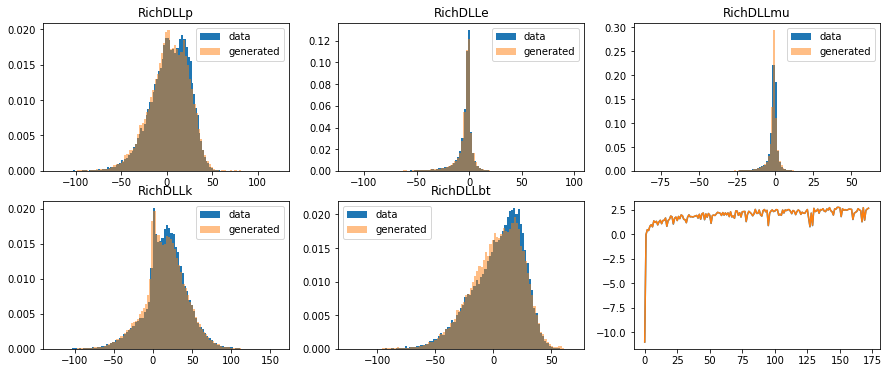

KeyboardInterrupt: 

In [21]:
epoches = 100000
n_samples = 50000
for i in range(step_freq * len(metrics_ll_train), epoches):
    model.train()
    optimizer.zero_grad()
    Y_batch, X_batch = next(data_gen)
    z, logp_z, log_det = model(Y_batch, X_batch)
    logp_x = logp_z + log_det
    loss = -torch.mean(logp_x)
    loss.backward()
#     torch.nn.utils.clip_grad_value_(model.parameters(), 10.0)
    optimizer.step()

    if i % step_freq == 0:
        model.eval()
        with torch.no_grad():
            metrics_ll_train.append(torch.mean(
                model.log_prob(Y_train_tensor[:n_samples], X_train_tensor[:n_samples])
            ).item())
            metrics_ll_test.append(torch.mean(
                model.log_prob(Y_test_tensor[:n_samples], X_test_tensor[:n_samples])
            ).item())
            
            samples = model.sample(
                X_test_tensor[:n_samples],
                batch_size=n_samples,
                post_map=preprocessor.y_scaler.inverse_transform
            )
        
        if metrics_ll_train[-1] > best_loss:
            best_loss = metrics_ll_train[-1]
            torch.save(model.state_dict(), f'{model_dir}/best_model')
            torch.save(optimizer.state_dict(), f'{model_dir}/best_optim')

        clear_output(True)
        print(np.mean(metrics_ll_train[-10:]))
        fig, axs = plt.subplots(2, 3, figsize=(15, 6))
        
        axs[1, 2].plot(metrics_ll_train)
        axs[1, 2].plot(metrics_ll_test)

        for i in range(dim):
            axs[i // 3, i % 3].hist(Y_val_[:n_samples, i], 100, label="data", density=True)
            axs[i // 3, i % 3].hist(samples[:, i], 100, label="generated", density=True, alpha=0.5)
            axs[i // 3, i % 3].legend()
            axs[i // 3, i % 3].set_title(dlls[i])
        
        plt.show()

In [16]:
! ls {model_dir}

In [18]:
model.load_state_dict(torch.load(f'{model_dir}/best_model'))

<All keys matched successfully>

In [22]:
samples = model.sample(
    X_test_tensor,
    post_map=preprocessor.y_scaler.inverse_transform
)

d1 = pd.DataFrame(np.hstack([Y_val_, X_val, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d2 = pd.DataFrame(np.hstack([samples, X_val, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d1['IsReal'] = True
d2['IsReal'] = False
d2.head()

/home/user/miniconda3/envs/py36/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsReal
0,19.232771,3.754274,1.196984,27.386534,19.204763,-0.139393,-0.307262,0.068216,0.485235,False
1,1.338270,-11.198304,12.348275,1.433070,1.296507,-2.118963,0.874966,2.099937,0.030539,False
2,10.280187,1.529175,7.345058,7.000631,10.285282,-0.611815,0.821342,-0.223614,1.179230,False
3,25.244383,-1.792772,0.489879,25.237982,25.179787,-1.062882,-0.386596,-0.129024,1.216820,False
4,-28.540182,-2.025134,0.986395,-33.544392,-28.535679,-0.588364,-1.507533,0.284726,1.219050,False


## Original data distributions

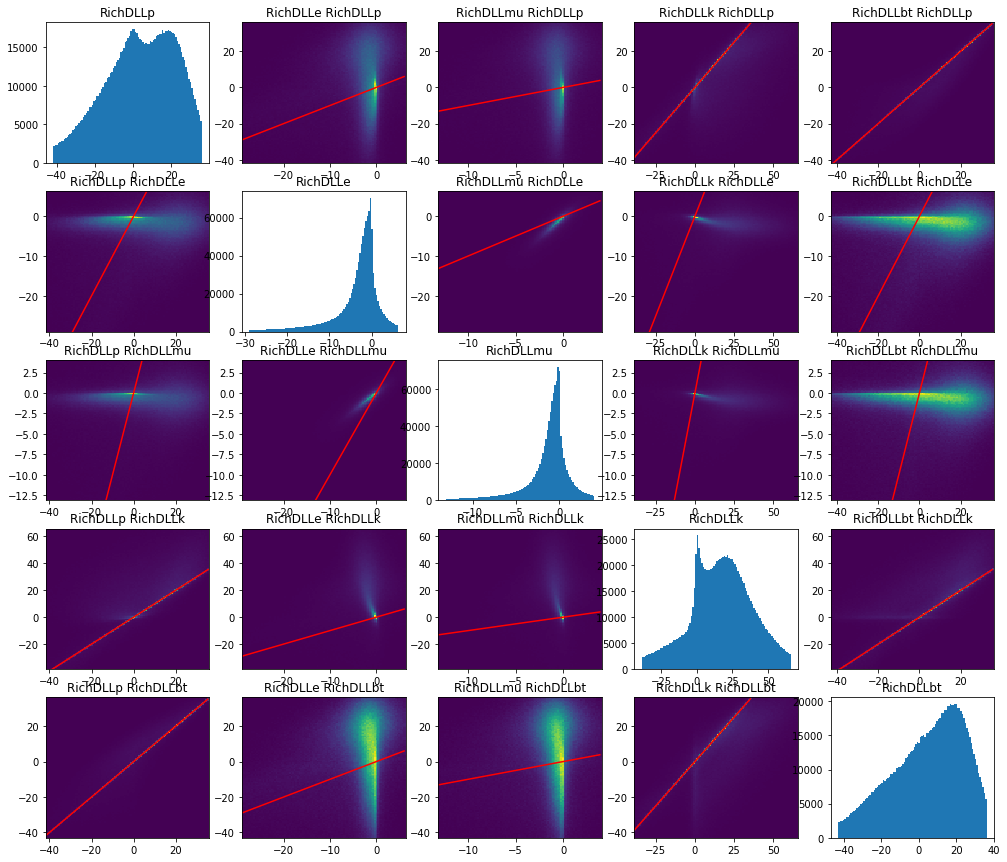

In [23]:
plot_joint_dll_distributions(d1, dlls)

## Generated data distributions

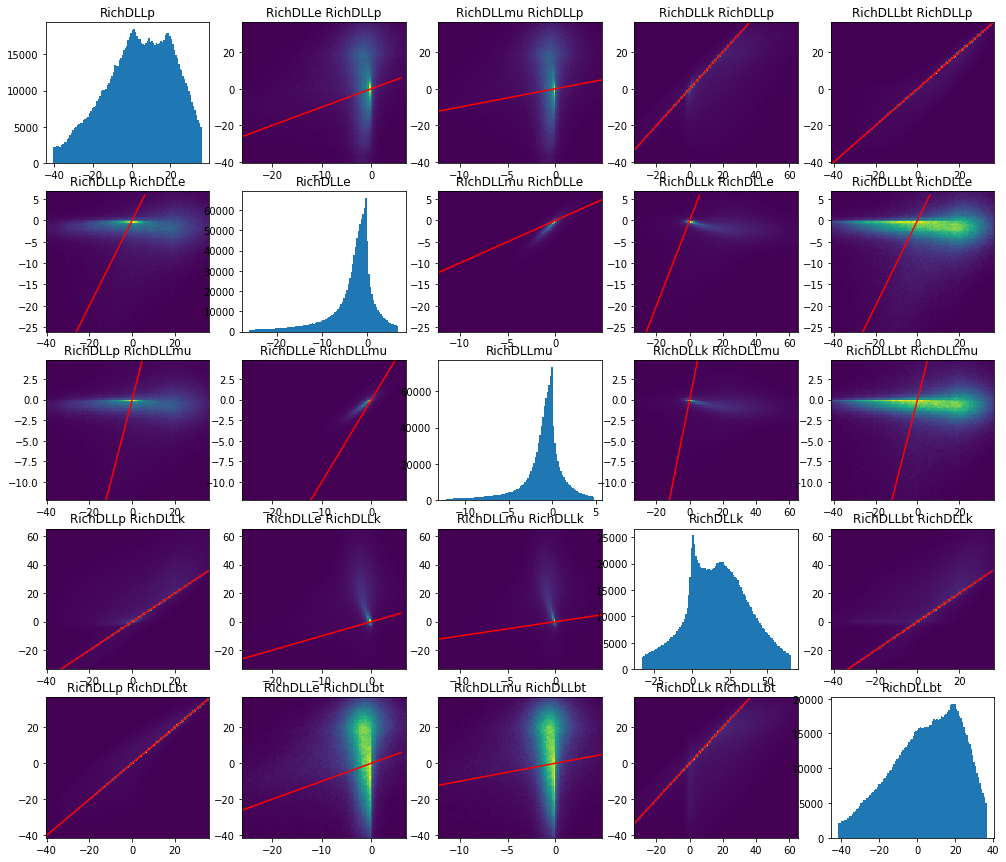

In [24]:
plot_joint_dll_distributions(d2, dlls)

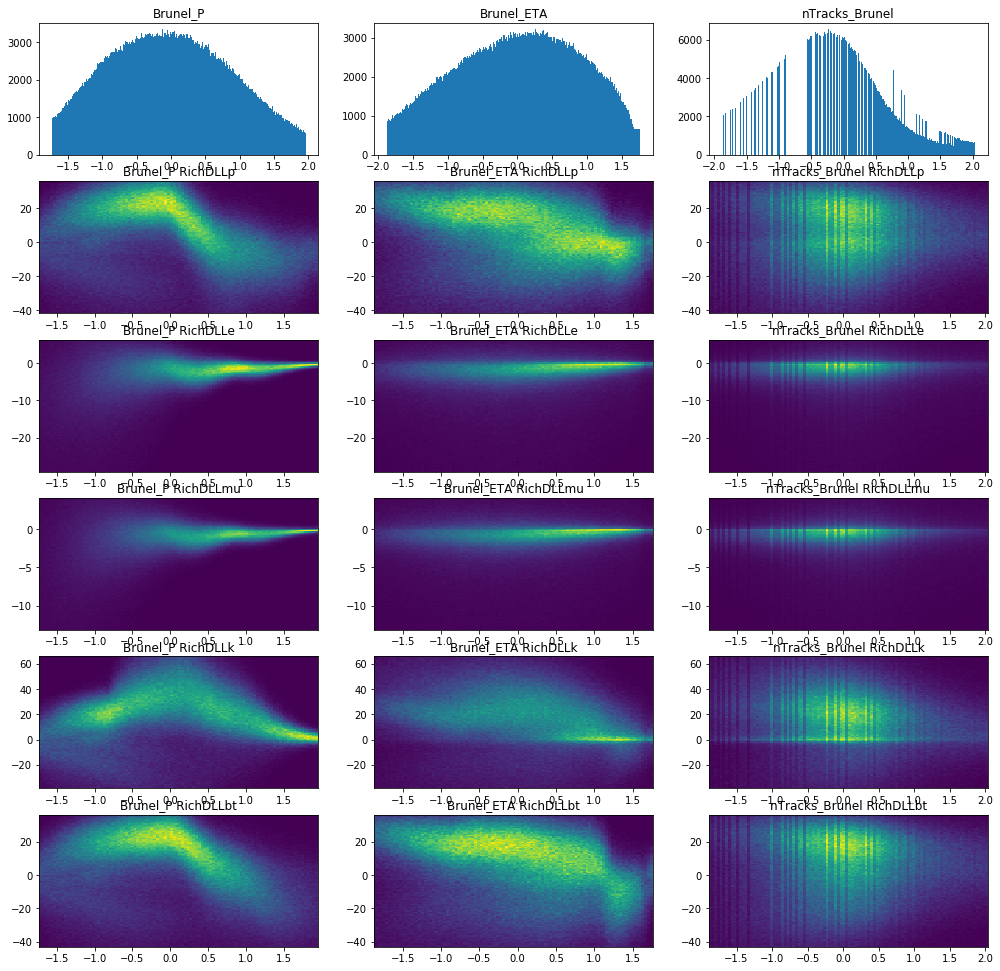

In [25]:
plot_joint_cond_dll_distributions(d1, dlls, features)

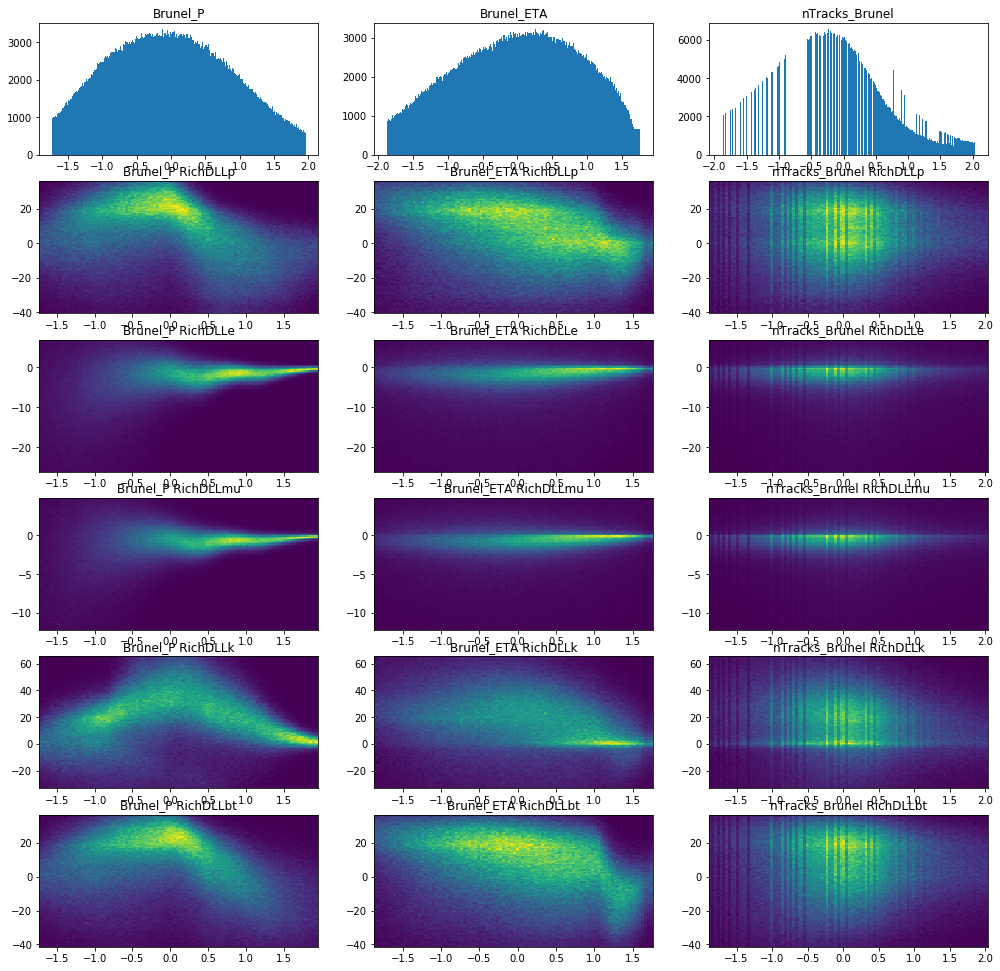

In [26]:
plot_joint_cond_dll_distributions(d2, dlls, features)

In [27]:
classification_ds = pd.concat([d1, d2]).sample(frac=1)
classification_ds.head(10)

,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsReal
579305,-3.793630,3.995380,2.529790,1.596290,-14.878600,0.529907,1.404855,0.632934,1.200290,True
837061,-9.355350,0.747412,0.279470,0.202065,12.505400,1.245831,0.932223,2.174674,-0.514216,True
1175837,-23.658400,-19.163099,-8.775660,-20.097700,-23.658400,-0.644221,-0.034732,1.345677,1.037550,True
746344,-36.481499,-5.551240,-2.446300,-25.100100,-27.429300,0.272608,1.163745,-0.016964,-0.502690,True
876680,10.734984,-6.401881,-2.302673,1.696811,10.744460,-0.429022,0.585434,1.720110,1.231890,False
1138130,9.665969,-1.613521,0.817472,24.344536,10.726899,0.044642,0.409078,-0.006109,1.057000,False
23370,-48.671398,0.742613,1.998920,-52.144600,-40.864399,0.603007,1.111568,-0.211534,-2.834890,True
82753,28.670082,-2.801118,-1.590059,40.886917,30.092199,-0.016062,0.711954,-0.455119,0.026310,False
1023839,26.576956,-0.441071,0.087422,56.056908,27.298048,-0.100181,1.084358,-1.453137,1.169830,False
549311,-28.500401,-31.009100,-9.592120,-28.500401,-28.500401,-1.149610,-0.953176,1.759480,0.041612,True


In [28]:
n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]
cls_train.shape, cls_val.shape

((1665393, 10), (713741, 10))

In [29]:
xgb_model = xgb.XGBClassifier(**params)

In [30]:
xgb_model.fit(
    X=cls_train[dlls + features].values,
    y=cls_train['IsReal'].values.astype('int32'),
)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=24, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [31]:
is_gen_pred = xgb_model.predict(cls_val[dlls + features].values)
is_gen_pred_probas = xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1]
is_gen_true = cls_val['IsReal'].values
cls_weights = cls_val[weight_filed].values

In [32]:
print('Accuracy =', np.sum(is_gen_pred == is_gen_true) / len(is_gen_pred))
print('ROC AUC =', roc_auc_score(is_gen_true, is_gen_pred_probas))
print('Weighted AUC ROC =', my_roc_auc(is_gen_true, xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1], cls_weights))

Accuracy = 0.5704940587692174
ROC AUC = 0.6063107876581304
Weighted AUC ROC = 0.6092429230134723


In [33]:
samples = model.sample(
    X_train_tensor,
    post_map=preprocessor.y_scaler.inverse_transform
)
d1 = pd.DataFrame(np.hstack([Y_train_, X_train, w_train.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d2 = pd.DataFrame(np.hstack([samples, X_train, w_train.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d1['IsReal'] = True
d2['IsReal'] = False

classification_ds = pd.concat([d1, d2]).sample(frac=1)

n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]

cls_train.head(10)

/home/user/miniconda3/envs/py36/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsReal
2560781,36.362400,-0.524101,-1.602810,35.873001,36.362400,-0.197896,0.302017,-0.611631,0.897785,True
310686,-1.216320,-1.253540,-0.233146,5.002230,-42.035400,1.996243,0.757509,-1.917829,-0.630917,True
190724,4.844377,0.449283,0.974343,4.829656,4.829253,-1.268631,-1.792061,0.775177,1.217570,False
2357878,32.077801,0.857243,1.324030,50.739799,32.081299,-0.136350,-0.272292,-0.441501,1.213620,True
1048712,5.942760,0.006287,0.008267,-1.179160,-2.614020,1.527627,-1.185461,-0.163954,1.111790,True
2074457,27.884199,-2.937490,-1.147560,22.260700,27.884199,-0.173535,0.507519,-0.510573,1.182120,True
690820,-11.595000,-1.420360,-0.619449,12.954200,-4.739080,0.600295,-0.758837,-0.140598,1.014550,True
531752,23.914686,4.873543,1.704802,52.683674,25.452471,0.128850,-0.170522,0.419529,1.035330,False
324308,6.217230,-2.247720,1.092580,6.217230,6.217230,-1.203817,-0.022650,-1.750168,-0.571009,True
156255,17.010401,-5.684360,-0.945065,40.544498,17.010401,-0.151099,-0.362798,-1.136543,1.343480,True


In [34]:
clf = CatBoostClassifier(
    **cb_params
).fit(
    cls_train[dlls + features].values,
    cls_train['IsReal'].values.astype('int32'),
    eval_set=(
        cls_val[dlls + features].values,
        cls_val['IsReal'].values.astype('int32'),
    )
)

Learning rate set to 0.351275
0:	test: 0.5326776	best: 0.5326776 (0)	total: 564ms	remaining: 9m 23s
100:	test: 0.6164840	best: 0.6164840 (100)	total: 27.4s	remaining: 4m 3s
200:	test: 0.6267730	best: 0.6267730 (200)	total: 55.1s	remaining: 3m 39s
300:	test: 0.6355554	best: 0.6355554 (300)	total: 1m 21s	remaining: 3m 9s
400:	test: 0.6421436	best: 0.6421436 (400)	total: 1m 48s	remaining: 2m 42s
500:	test: 0.6472155	best: 0.6472155 (500)	total: 2m 15s	remaining: 2m 15s
600:	test: 0.6515580	best: 0.6515580 (600)	total: 2m 44s	remaining: 1m 48s
700:	test: 0.6547793	best: 0.6547793 (700)	total: 3m 11s	remaining: 1m 21s
800:	test: 0.6579867	best: 0.6579867 (800)	total: 3m 39s	remaining: 54.5s
900:	test: 0.6605893	best: 0.6605893 (900)	total: 4m 5s	remaining: 26.9s
999:	test: 0.6627298	best: 0.6627298 (999)	total: 4m 30s	remaining: 0us

bestTest = 0.6627298404
bestIteration = 999



In [35]:
preds = clf.predict(cls_train[dlls + features], prediction_type='RawFormulaVal')

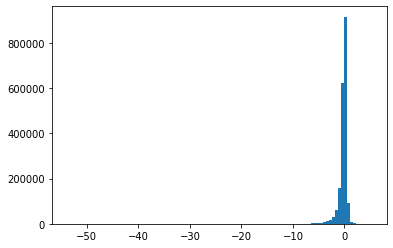

In [36]:
plt.hist(preds[~cls_train['IsReal'].values], bins=100);

In [44]:
clf_wrapper = lambda x: np.clip(clf.predict(x, prediction_type='RawFormulaVal'), -100, np.log(2))

In [47]:
samples = rejection_sampling(clf_wrapper, model, 2, X_test_tensor, preprocessor.y_scaler.inverse_transform)
d1 = pd.DataFrame(np.hstack([Y_val_, X_val, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d2 = pd.DataFrame(np.hstack([samples, X_val, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d1['IsReal'] = True
d2['IsReal'] = False

n = d1.shape[0]
classification_ds = pd.concat([d1, d2]).sample(frac=1)

n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]

cls_train.head(10)

/home/user/miniconda3/envs/py36/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsReal
680973,-23.564899,-2.352040,-0.281464,36.178101,-2.101350,0.645946,0.859846,-0.285182,1.192920,True
1089623,-9.647690,-28.026800,-12.181200,-9.647690,-9.647690,-1.274796,-0.115038,-0.765864,0.442626,True
493277,-18.607780,-0.718040,-0.200508,9.687992,1.788988,1.094601,0.976474,0.357792,1.210720,False
635524,-15.627600,-15.512300,-12.079100,-15.627600,-15.627600,-1.768486,-0.816376,0.775177,-0.003406,True
753791,6.283690,-0.696517,-5.288770,6.283690,6.283690,-1.412570,0.175696,-0.348781,1.162180,True
433869,-7.119710,-0.290999,-0.125875,2.132360,-6.870290,1.789961,0.352547,1.382887,0.647873,True
1138615,-17.786200,0.366817,0.164171,-7.857150,-15.906600,1.628950,1.821419,0.247128,0.686262,True
195656,-1.871020,-1.285410,-0.041223,25.573500,8.523940,0.211065,0.980488,0.973860,0.541524,True
912561,19.908543,-4.518857,0.944321,36.245304,19.892725,-0.630436,-0.021706,0.470915,0.132857,False
56872,10.021345,22.523043,-3.307026,10.080677,10.010213,-1.150280,0.593364,0.159747,1.333490,False


In [48]:
xgb_model = xgb.XGBClassifier(**params)

xgb_model.fit(
    X=cls_train[dlls + features].values,
    y=cls_train['IsReal'].values.astype('int32'),
#     sample_weight=cls_train[weight_filed]
)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=24, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [49]:
is_gen_pred = xgb_model.predict(cls_val[dlls + features].values)
is_gen_pred_probas = xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1]
is_gen_true = cls_val['IsReal'].values
cls_weights = cls_val[weight_filed].values

print('Accuracy =', np.sum(is_gen_pred == is_gen_true) / len(is_gen_pred))
print('ROC AUC =', roc_auc_score(is_gen_true, is_gen_pred_probas))
print('Weighted AUC ROC =', my_roc_auc(is_gen_true, xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1], cls_weights))

Accuracy = 0.5208457970047958
ROC AUC = 0.536717452353361
Weighted AUC ROC = 0.5226708392114348


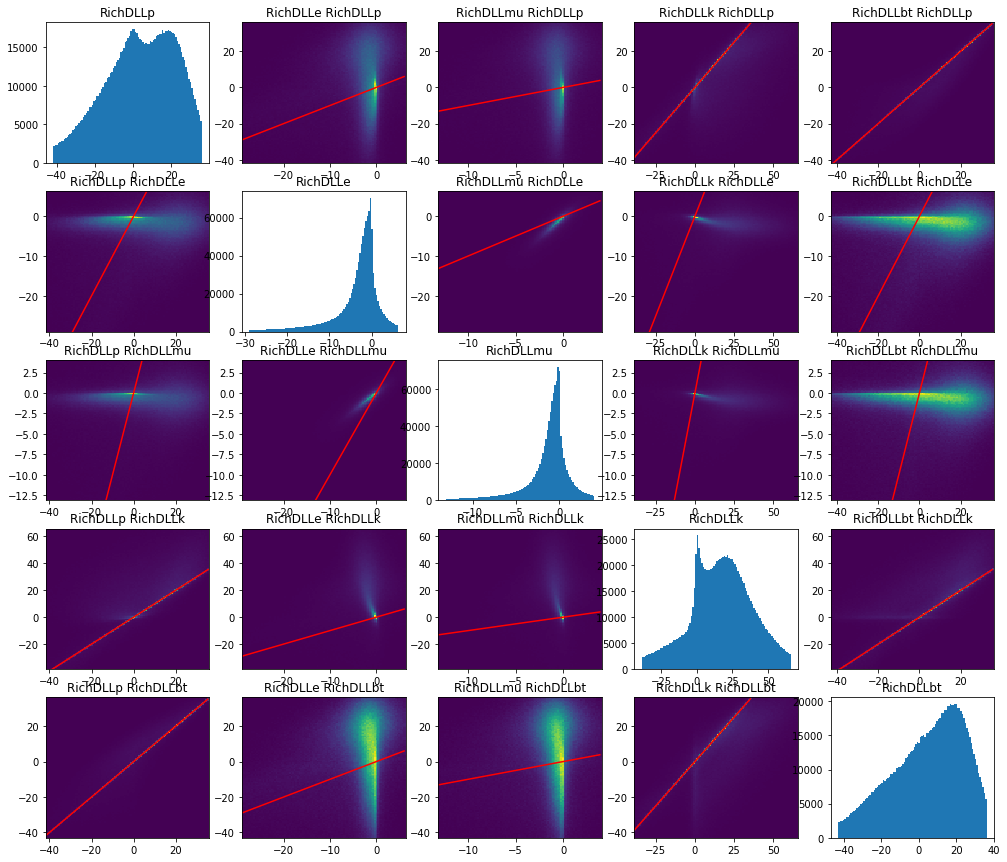

In [50]:
plot_joint_dll_distributions(d1, dlls)

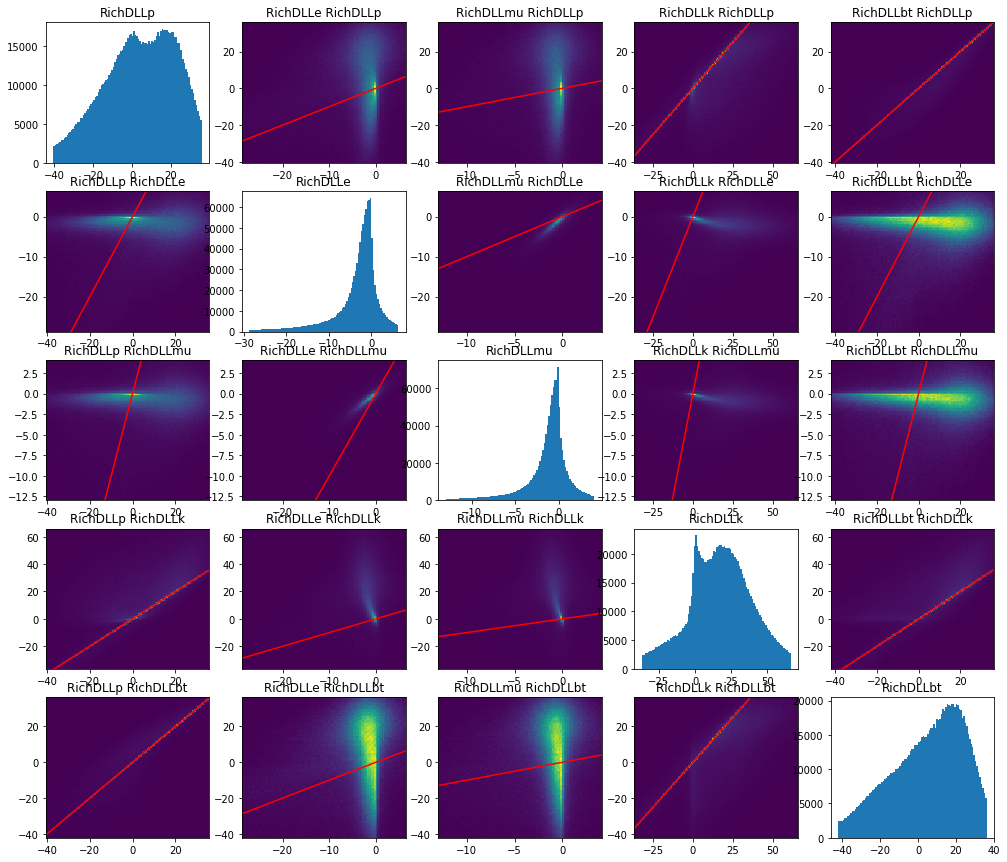

In [51]:
plot_joint_dll_distributions(d2, dlls)

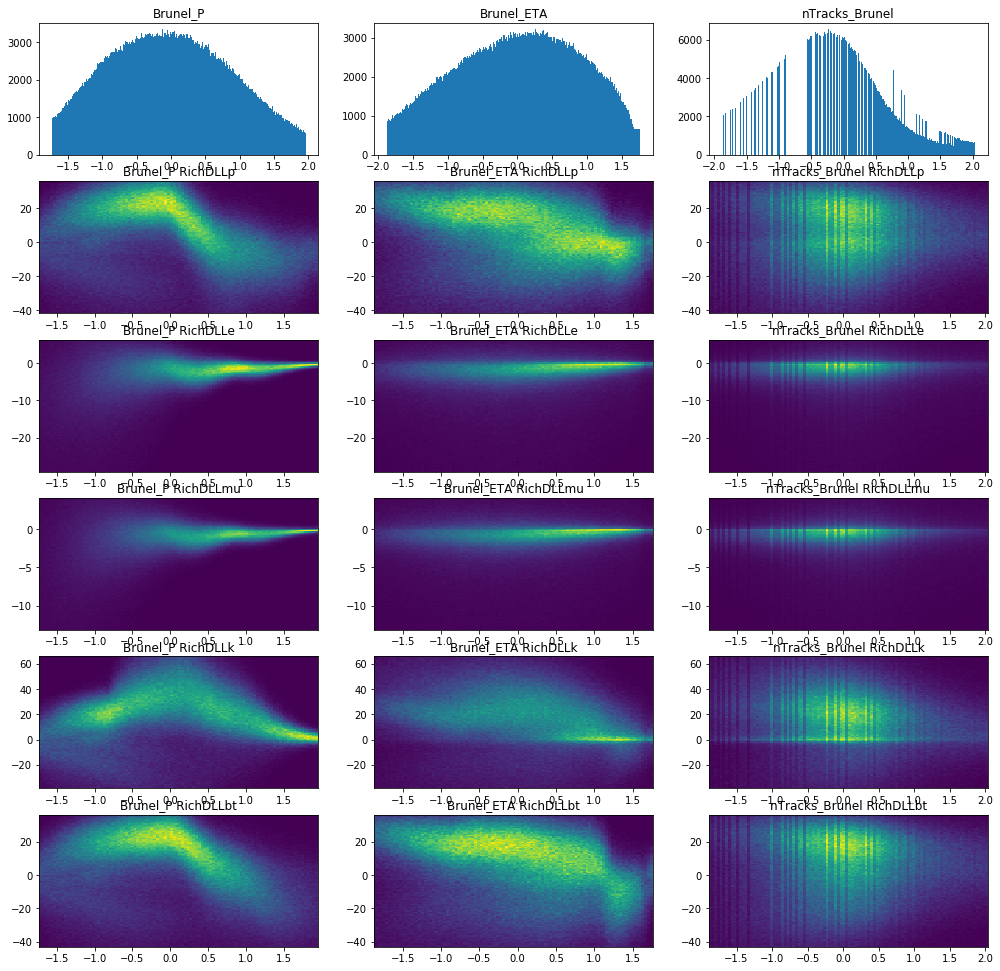

In [52]:
plot_joint_cond_dll_distributions(d1, dlls, features)

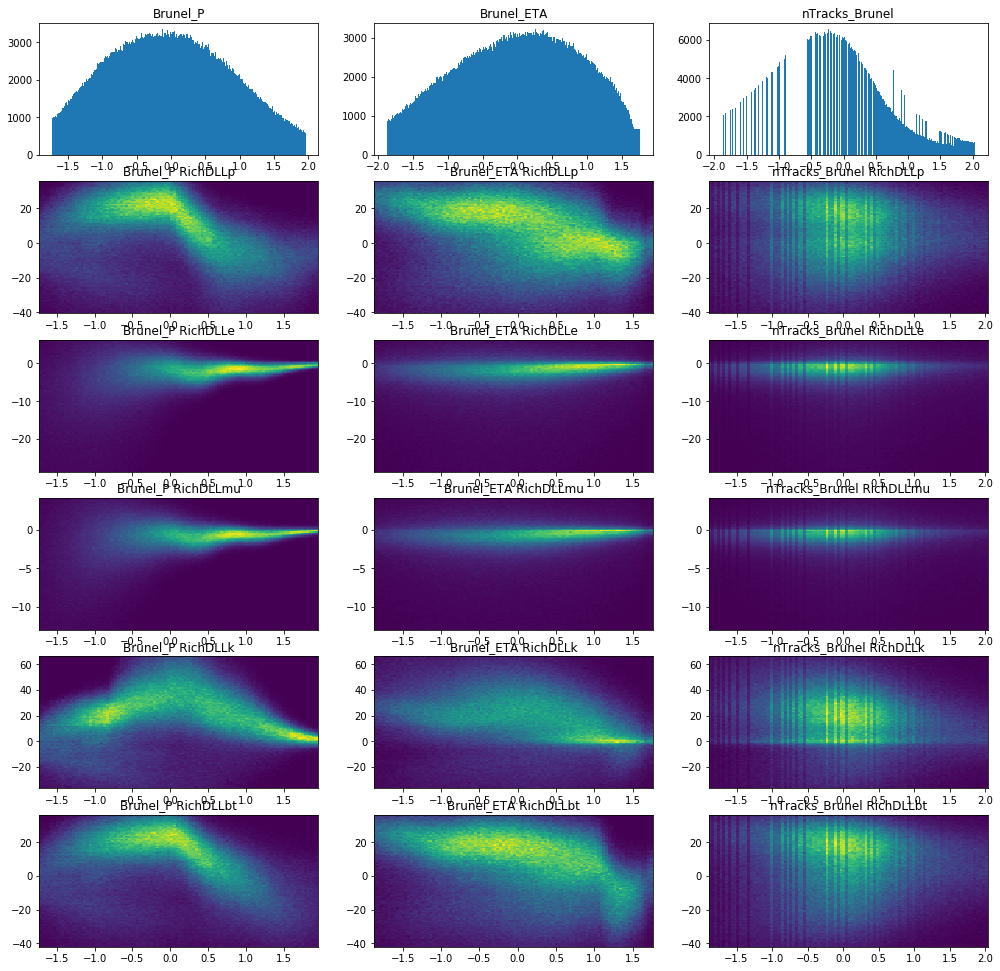

In [53]:
plot_joint_cond_dll_distributions(d2, dlls, features)